In [17]:
## IMPORTING ALL THE LIBRARIES WE CARE ABOUT

#import euclidemu2
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
import pandas as pd


from scipy.stats import qmc



In [18]:
## SET UP LHS
## 8 PARAMETERS

def make_LHS(dim,num, lower_bound,upper_bound):

    sampler = qmc.LatinHypercube(d=dim)
    sample = sampler.random(n=num)

    new_sample = sample.copy().T
    for i in range(len(sample[0])):
        print(sample[i])
        new_sample[i] = new_sample[i] * (upper_bound[i] - lower_bound[i]) + lower_bound[i]
    return new_sample
# 0.24 <= Omega_m <= 0.4 
# 0.8 <= n_s <= 1.2
# 1.7 <= A_s1e9 <= 2.5
#0.5 <= h <= 0.9
sample = make_LHS(4,50, [0.24,0.8,1.7e-9,0.5],[0.4,1.2,2.5e-9,0.9])
print(sample.shape)


[0.12391434 0.75141211 0.09161892 0.56738936]
[0.46068471 0.15680296 0.85347427 0.40019193]
[0.65793095 0.10208322 0.01150424 0.00966035]
[0.66663549 0.44961048 0.59899543 0.28035032]
(4, 50)


In [19]:
## SET UP EUCLIDEMULATOR2

#ee2=euclidemu2.PyEuclidEmulator()

#cosmo_par={'As':2.1e-09, 'ns':0.966, 'Omb':0.04,'Omm':0.3,'h':0.68,'mnu':0.15,'w':-1.0,'wa':0.0}
#redshifts=[0,2,4,6,8,10]

#k, pnl, plin, b = ee2.get_pnonlin(cosmo_par, redshifts)

In [ ]:
## Power spectrum from CCL - backscaling

Pk_ccl = np.zeros((len(sample[0]),500))

## Linear Power spectra
for i in range(len(sample[0])):
    
    wb = 0.0223
    wr = 0.0
    
    ns = sample[1]
    As = sample[2]
    h = sample[3]
    wm = sample[0]*h**2

    kk_ccl = np.logspace(-3,1,len(Pk_ccl[0]))*h[i]               # in 1/Mpc
    cosmoLCDM = ccl.Cosmology(Omega_c=(wm[i] - wb)/h[i]**2,
                               Omega_b=wb/h[i]**2, 
                               A_s=As[i], 
                               h = h[i],
                               n_s=ns[i],
                               Omega_k=0)

# Omega_g::: Note that if a non-None value is given, this may result in a physically 
# inconsistent model because the CMB temperature will still be non-zero in the parameters.
    cosmoLCDM_norad = ccl.Cosmology(Omega_c=(wm[i] - wb)/h[i]**2,
                               Omega_b=wb/h[i]**2, 
                               A_s=As[i], 
                               h = h[i],
                               n_s=ns[i],
                               Omega_k=0,
                               Omega_g = 0,
                               T_CMB = 0.0)

    Pk_0 = ccl.power.linear_matter_power(cosmoLCDM, kk_ccl, 1)    # in (Mpc)^3

    Growth_0 = ccl.background.growth_factor(cosmoLCDM_norad, 1)

    Growth_49 = ccl.background.growth_factor(cosmoLCDM_norad, 1/(1+49))

    Pk_ccl[i] = (Growth_49/Growth_0)**2 * Pk_0*h[i]**3    # in (Mpc)^3/h^3

    kk_ccl = kk_ccl/h[i]    # in h/Mpc
    #np.savetxt(working_dir + 'decideonnamelater_{}.dat'.format(i), np.array([kk_ccl, Pk_ccl[i]]).T)

kk_ccl = np.logspace(-3,1,500)

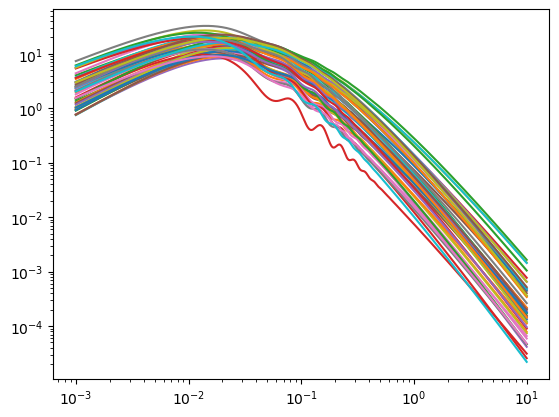

In [15]:
for i in range(len(sample[0])):
    plt.loglog(kk_ccl,Pk_ccl[i])

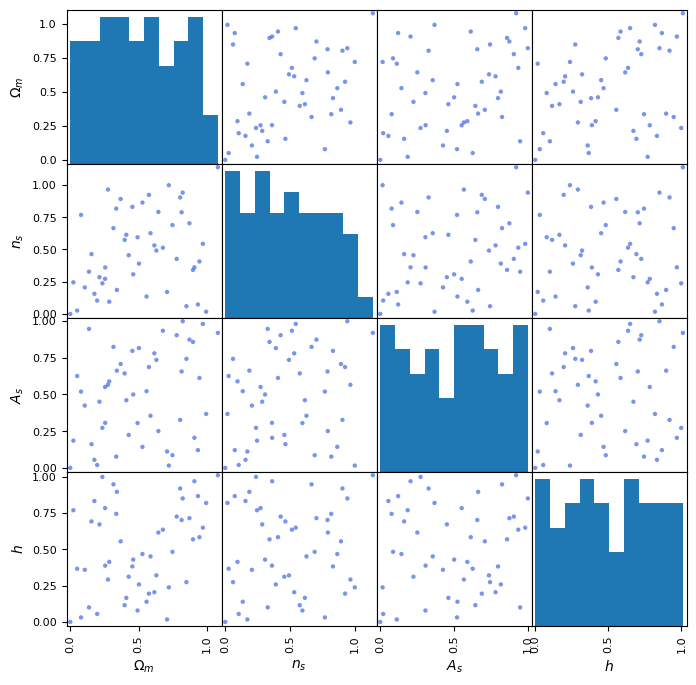

In [8]:
df_theta_emu = pd.DataFrame(sample, columns=[r'$\Omega_m$', r'$n_s$', r'$A_s$', r'$h$'][:len(sample)])

# Customization options
color_emu = "royalblue"   # Color for df_theta_emu
color_val = "crimson"     # Color for df_theta_val
s = 10                    # Marker size
tick_size = 12            # Tick label size
label_size = 14           # Axis label size
tick_rotation = 45        # Rotation angle for tick labels
diag_color = "black"      # Color for diagonal histograms/KDE

# Create scatter matrix for the first dataset
scatter_matrix_fig = pd.plotting.scatter_matrix(
    df_theta_emu, 
    figsize=(8, 8), 
    color=color_emu, 
    marker='o', 
    s=s, 
    alpha=0.7,
    density_kwds={'color': diag_color, 'linewidth': 2},
)
